In [6]:
#general & system\n",
import os

#data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data augmentation
from PIL import Image
from random import choice
#import cv2
import numpy as np
#import keras.preprocessing.image as prep

#ML part
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image as kimage
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout,Activation,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

%matplotlib inline

Using TensorFlow backend.
/Users/sararabhi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load the image data 

In [7]:
%%time
meta = pd.read_csv("../data/metadata.csv")

CPU times: user 32.4 ms, sys: 9.41 ms, total: 41.8 ms
Wall time: 51.3 ms


In [8]:
%%time
filelist = os.listdir("../data/resized/")
X_train = np.array([np.array(Image.open("../data/resized/"+fname)) for fname in filelist])

CPU times: user 24.8 s, sys: 6.45 s, total: 31.3 s
Wall time: 37.1 s


In [9]:
X_train.shape

(13786, 299, 299, 3)

# Load Targets 

In [10]:
#get target
filelist = [x.replace(".jpg","") for x in filelist]
strates = [meta[meta["name"]==x]["meta_clinical_benign_malignant"].values[0] for x in filelist]
Y_train = [1 if x=="malignant" else 0 for x in strates]

In [11]:
#control
print(filelist[0:5])
print(Y_train[0:5])
print(strates[0:5])

['ISIC_0009001', 'ISIC_0006332', 'ISIC_0010550', 'ISIC_0011896', 'ISIC_0000743']
[0, 0, 1, 0, 0]
['benign', 'benign', 'malignant', 'benign', 'benign']


# Resampling to handle imbalenced data 

In [12]:
# TODO

# data splitting


In [13]:
#data splitting
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, random_state=42, train_size=0.80,
                                                      stratify = strates)

/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Load the base model :

In [14]:
weights_path = '../model/checkpoints/'

if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
epochs = 500
batch_size = 5

In [15]:
#load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299,299,3))
base_model.summary()

94617600/94653016 [============================>.] - ETA: 0s____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 150, 150, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 150, 150, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 150, 150, 64)  0           bn_conv1[0][0]                   
_______________________________

## Validate the features extracted from fixed model 

visualizing for Resnet
Converting data points to composite image
we got 2758 different images of shape 299x299 
build usefull features from the selected model
performing t-sne reduction


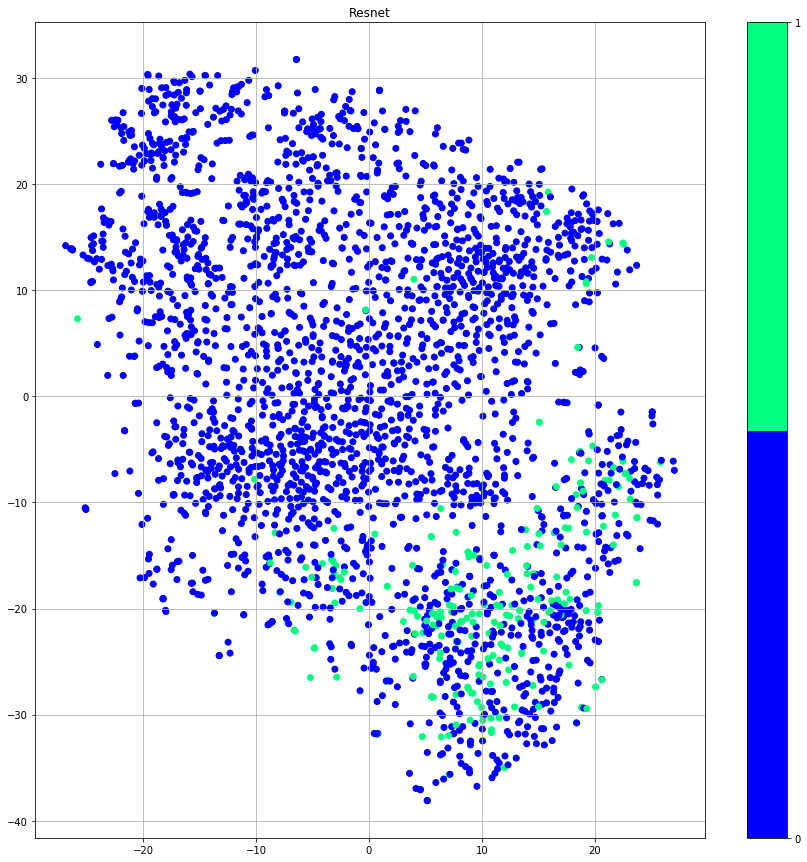

In [32]:
%matplotlib inline
import numpy as np
# visualize the points' distribution of train data using features built from base_model
import matplotlib.pyplot as plt
# dimension reduction
from sklearn.manifold import TSNE 
import numpy as np

def t_sne_vis(name, base_model, x_processed_images, random_state, labels):
    """
    :param name: the name of the cnn model used to build features
    :param base_model: the model obj
    :param x_processed_images: the input images for our model
    :param random_state: for fixing the results
    :param labels: 0/1 classification labels
    :return:
    the graph of image distribution based on features extracted from the model and the t-sne features
    """
    # convert data to images
    print('Converting data points to composite image')
    X_train = x_processed_images
    print('we got %d different images of shape %dx%d ' % (len(X_train), X_train.shape[1], X_train.shape[1]))
    print('build usefull features from the selected model')
    features = base_model.predict(X_train)
    x_data1 = np.asarray(features).astype('float64')
    x_data1 = x_data1.reshape((x_data1.shape[0], -1))
    # perform t-SNE embedding
    print('performing t-sne reduction')
    vis_data = TSNE(perplexity=100, random_state=random_state).fit_transform(x_data1)
    # plot the result
    fig = plt.figure(figsize=(15, 15))
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("winter", 2))
    plt.colorbar(ticks=range(2))
    plt.clim(0, 1)
    plt.title(name)
    plt.grid()
    plt.show()
    fig.savefig('tsne_vis_'+name+'.png')
    return vis_data


name = 'Resnet'
print('visualizing for %s' %name)
tsne_feats = t_sne_vis(name, base_model, X_valid, np.random.RandomState(42), Y_valid)

# Classification benchmark of Simple ML models

# HyperOpt: Hyper-paramter optimisation 

In [35]:
from hyperopt import hp
space4search = {

    'multinomial_naive_bayes': hp.choice('classifier_type', [
        {
            'type': 'multinomoial_naive_bayes',
            'data_input': hp.choice('input_data', ['t-sne']),
            'alpha': hp.uniform('alpha_m', 0.0, 2.0)

        }    ]
                                         ),

    'Bernoulli_naive_bayes': hp.choice('classifier_type', [
        {
            'type': 'multinomoial_naive_bayes',
            'data_input': hp.choice('input_data', ['t-sne']),
            'alpha': hp.uniform('alpha_m', 0.0, 2.0)
        }
    ]),
    'LR': hp.choice('classifier_type', [
        {
            'type': 'LR',
            'data_input': hp.choice('input_data', ['t-sne']),
            'C': hp.uniform('C_LR', 0, 10.0)
        }

    ]),

    'svm': hp.choice('classifier_type', [
        {
            'type': 'svm',
            'data_input': hp.choice('input_data', ['t-sne']),
            'C': hp.uniform('C', 0, 10.0),
            'kernel': hp.choice('kernel', ['linear', 'rbf']),
            'gamma': hp.uniform('gamma', 0, 20.0)
        }

    ]),

    'RF': hp.choice('classifier_type', [
        {
            'type': 'RF',
            'max_depth': hp.choice('max_depth', range(1100)),
            'max_features': hp.choice('max_features', range(1, 200)),
            'data_input': hp.choice('input_data', ['t-sne']),
            'n_estimators': hp.choice('n_estimators', range(1, 1000)),
            'criterion': hp.choice('criterion', ["gini", "entropy"]),
        }
    ]),

    'ET': hp.choice('classifier_type', [{
        'type': 'ET',
        'max_depth': hp.choice('max_depth_ET', range(1100)),
        'max_features': hp.choice('max_features_ET', range(1, 200)),
        'data_input': hp.choice('input_data', ['t-sne']),
        'n_estimators': hp.choice('n_estimators_ET', range(1, 1000)),
        'criterion': hp.choice('criterion_ET', ["gini", "entropy"]),
    }]),

    'k-nn': hp.choice('classifier_type', [{
        'type': 'k-nn',
        'data_input': hp.choice('input_data', ['t-sne']),
        'n_neighbors': hp.choice('knn_n_neighbors', range(2, 100))
    }]),

    'GB': hp.choice('classifier_type', [
        {
            'type': 'GB',
            'max_depth': hp.choice('max_depth', range(1100)),
            'max_features': hp.choice('max_features', range(1, 200)),
            'data_input': hp.choice('input_data', ['t-sne']),
            'n_estimators': hp.choice('n_estimators', range(1, 1000)),
            'learning_rate': hp.uniform('learning_rate', 0, 1.0),
        }
    ])
}


input_matrices={'t-sne': tsne_feats}
y = Y_valid

In [40]:
from Hyper_opt_ML_models import hyper_opt_f
hyper_opt_f(tsne_feats, Y_valid, input_matrices, space4search)

optimization of the model: multinomial_naive_bayes
 
best:
{'alpha_m': 1.3898534862522238, 'classifier_type': 0, 'input_data': 0}
 
 
optimization of the model: Bernoulli_naive_bayes
 
best:
{'alpha_m': 0.5186951296581224, 'classifier_type': 0, 'input_data': 0}
 
 
optimization of the model: LR
 
new best: 0.883592373075 {'C': 0.6901694331193953}
new best: 0.883910170537 {'C': 5.8373537452475155}


/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sarar

/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sarar

new best: 0.884091203027 {'C': 1.1081995688569657}


/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sarar

best:
{'C_LR': 1.1081995688569657, 'classifier_type': 0, 'input_data': 0}
 
 
optimization of the model: svm
 
new best: 0.902562191739 {'C': 7.140932185915073, 'gamma': 19.4923454999464, 'kernel': 'rbf'}
new best: 0.90692764843 {'C': 4.062025405642775, 'gamma': 0.19665358875725847, 'kernel': 'rbf'}


/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sararabhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 